In [4]:
# Importing libraries
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from datasets import Dataset
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from transformers import GPT2Tokenizer, GPT2Model
from langdetect import detect
from collections import Counter


ModuleNotFoundError: No module named 'langdetect'

In [ ]:
# Load data
data = pd.read_csv('all_ECB_speeches.csv',sep = '|')

In [ ]:
# Remove non-english speeches

# Function to detect language of a given text
def detect_language(text):
    try:
        lang = detect(text)
    except:
        lang = "Unknown"
    return lang

# Apply the language detection function to each text in your DataFrame
data['language'] = data['contents'].apply(detect_language)

# Filter out the texts that are not in English
data = data[data['language'] == 'en']


In [ ]:
# Drop null values
data = data.dropna(subset=['speakers','contents'])
# Reset index
data = data.reset_index(drop=True)
# Remove introduction
for row in range (data.shape[0]):
  try:
    speech = re.split(
        " \d+ (January|February|March|April|May|June|July|August|September|October|November|December) \d{4} ",
        data.loc[row, "contents"])
    data.loc[row, "contents"] = speech[-1]
  except:
    pass        

In [ ]:
# Split into sentences
sentences_list = []
for row in range (data.shape[0]):
    text = data.loc[row, "contents"]
    sentences = re.split(r'[.!?]', text)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    sentences_list.append(sentences)
data['sentences'] = sentences_list


In [ ]:
# Remove stopwords and punctuation
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stop_words.update(['also', 'ha'])
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text, re.UNICODE)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

sentences_list = []
original_sentences = []
for row in range (data.shape[0]):
    sentences = data.loc[row, "sentences"]
    original_sentences.append(sentences)
    sentences = [preprocess_text(sentence) for sentence in sentences]
    sentences_list.append(sentences)

data['sentences'] = sentences_list
data['original_sentences'] = original_sentences


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lavin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lavin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lavin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data.head()

,date,speakers,title,subtitle,contents,language,sentences,original_sentences
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,[approach end legislative term wish sincerely ...,[As we approach the end of this legislative te...
1,2024-02-16,Isabel Schnabel,From laggard to leader? Closing the euro area’...,Inaugural lecture of the EMU Lab by Isabel Sch...,"More than 30 years after its inception, Econom...",en,[30 year inception economic monetary union wid...,"[More than 30 years after its inception, Econo..."
2,2024-02-15,Christine Lagarde,Hearing of the Committee on Economic and Monet...,"Speech by Christine Lagarde, President of the ...",Today’s hearing is our last before the end o...,en,"[today hearing last end legislative term, let ...",[Today’s hearing is our last before the end of...
3,2024-02-14,Piero Cipollone,Preserving people’s freedom to use a public me...,"Introductory statement by Piero Cipollone, Mem...",on the digital euro (CON/2023/34)”. See Ar...,en,"[digital euro con202334, see article 52 applic...","[on the digital euro (CON/2023/34)”, See Artic..."
4,2024-02-14,Luis de Guindos,"Monetary policy, financial stability and mediu...","Speech by Luis de Guindos, Vice-President of t...",Over the past few years the euro area economy ...,en,[past year euro area economy experienced unpre...,[Over the past few years the euro area economy...


In [ ]:
# Explode the data to have one sentence per row
sentences_df = data.explode('sentences')
# match the original sentences
# TODO
# Drop null values
sentences_df = sentences_df.dropna(subset=['sentences'])
sentences_df.head()


TypeError: unhashable type: 'list'

In [ ]:
# Create a dictionary of terms for each subject

dict_terms = {'inflation':
              ['inflation', 'prices', 'deflation', 'target', 'consumer prices', 'CPI', 'PPI'],
              'activity':
              ['activity', 'recovery', 'recession', 'expansion', 'output', 'demand', 'supply','GDP', 'employment', 'unemployment', 'labor market'],
              'economic crisis':
              ['crisis', 'recession', 'depression', 'bailout', 'stimulus', 'austerity', 'bankruptcy', 'default'],
              'monetary policy':
              ['monetary policy', 'interest rates', 'central bank', 'money supply', 'quantitative easing', 'policy rate', 'rate cut', 'rate hike', 'forward guidance', 'open market operations', 'reserve requirements'],
}



In [ ]:
# Find the sentences that contain the terms
topic_list = []
for row in range(sentences_df.shape[0]): 
    sentence = sentences_df.iloc[row, 6]
    topic = [0,0,0,0]
    for i, terms in enumerate(dict_terms.values()):
        for term in terms:
            if term in sentence:
                topic[i] += 1
    topic_list.append(topic)
topic_list

# Add the classification to the DataFrame and infer the topic based on the argmax of the topic list
# if no topic is found, the topic is set to unknown
# if multiple topics are found with the same number of terms, set it as unknown 
sentences_df['topic_matchs'] = topic_list
sentences_df['topic'] = sentences_df['topic_matchs'].apply(lambda x: list(dict_terms.keys())[x.index(max(x))] if max(x) > 0 and x.count(max(x)) == 1 else 'unknown')


In [ ]:
# Vectorize the sentences
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(sentences_df['sentences'])
X

<323796x47908 sparse matrix of type '<class 'numpy.float64'>'
	with 3271629 stored elements in Compressed Sparse Row format>

In [ ]:
clusters = KMeans(n_clusters=4, random_state=0).fit_predict(X)

c:\Users\Lavin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
sentences_df['cluster'] = clusters

In [ ]:
sentences_df

,date,speakers,title,subtitle,contents,language,sentences,original_sentences,topic_matchs,topic,cluster
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,approach end legislative term wish sincerely t...,[As we approach the end of this legislative te...,"[0, 0, 0, 0]",unknown,1
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,building collaborative spirit today debate dra...,[As we approach the end of this legislative te...,"[0, 0, 0, 0]",unknown,1
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,let start outlining current state euro area ec...,[As we approach the end of this legislative te...,"[0, 0, 0, 1]",monetary policy,2
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,focus need common european response strengthen...,[As we approach the end of this legislative te...,"[0, 0, 0, 0]",unknown,2
0,2024-02-26,Christine Lagarde,European Parliament plenary debate on the ECB ...,"Speech by Christine Lagarde, President of the ...",As we approach the end of this legislative ter...,en,bringing inflation back target challenging eco...,[As we approach the end of this legislative te...,"[2, 1, 0, 0]",inflation,2
...,...,...,...,...,...,...,...,...,...,...,...
2523,1997-02-07,Alexandre Lamfalussy,Conference organised by the Hungarian Banking ...,"Address by Alexandre Lamfalussy, President of ...","For at least three reasons, I have accepted wi...",en,feeling able avoid earlier western european ex...,"[For at least three reasons, I have accepted w...","[0, 0, 0, 0]",unknown,1
2523,1997-02-07,Alexandre Lamfalussy,Conference organised by the Hungarian Banking ...,"Address by Alexandre Lamfalussy, President of ...","For at least three reasons, I have accepted wi...",en,long time come customer need close human proxi...,"[For at least three reasons, I have accepted w...","[0, 0, 0, 0]",unknown,1
2523,1997-02-07,Alexandre Lamfalussy,Conference organised by the Hungarian Banking ...,"Address by Alexandre Lamfalussy, President of ...","For at least three reasons, I have accepted wi...",en,comparative assessment cost benefit two approa...,"[For at least three reasons, I have accepted w...","[0, 0, 0, 0]",unknown,1
2523,1997-02-07,Alexandre Lamfalussy,Conference organised by the Hungarian Banking ...,"Address by Alexandre Lamfalussy, President of ...","For at least three reasons, I have accepted wi...",en,hope ten year time still around shall able con...,"[For at least three reasons, I have accepted w...","[0, 0, 0, 0]",unknown,1


In [ ]:
# group by topic and cluster
grouped = sentences_df.groupby(['cluster','topic']).size().reset_index(name='counts')
# drop the unknown topic
grouped = grouped[grouped['topic'] != 'unknown']
grouped

,cluster,topic,counts
0,0,activity,1046
1,0,economic crisis,706
2,0,inflation,380
3,0,monetary policy,11783
5,1,activity,11230
6,1,economic crisis,8011
7,1,inflation,11218
8,1,monetary policy,1426
10,2,activity,2475
11,2,economic crisis,1212


In [ ]:
# some examples of the sentences in each cluster
for cluster in range(4):
    print(f'Cluster {cluster}:')
    print(sentences_df[sentences_df['cluster'] == cluster]['original_sentences'].sample(10).values)
    print('\n')


Cluster 0:
[list(['Ladies and gentlemen, I would like to thank the organisers Jan-Peter Krahnen and Hans-Helmut Kotz for inviting me to speak at the fifth edition of the Frankfurt Conference on Financial Market Policy', 'The theme of the conference is well-chosen', 'Despite significant improvements to its architecture over recent years, there is a clear sense that Economic and Monetary Union, or EMU, remains incomplete', 'There is much less clarity and precious little agreement on what a complete EMU would look like, however', 'This is why the question posed by the organisers – “how much federalism” – is so relevant', 'In my remarks, I would like to first review how federalism has evolved in the EU, highlighting that it is as much a process as it is an end-state', 'I will then – drawing on the economic concept of fiscal federalism – look more at the question of “how much federalism”, focusing on issue of risk-sharing and the role of different levels of governance within EMU', 'Federali

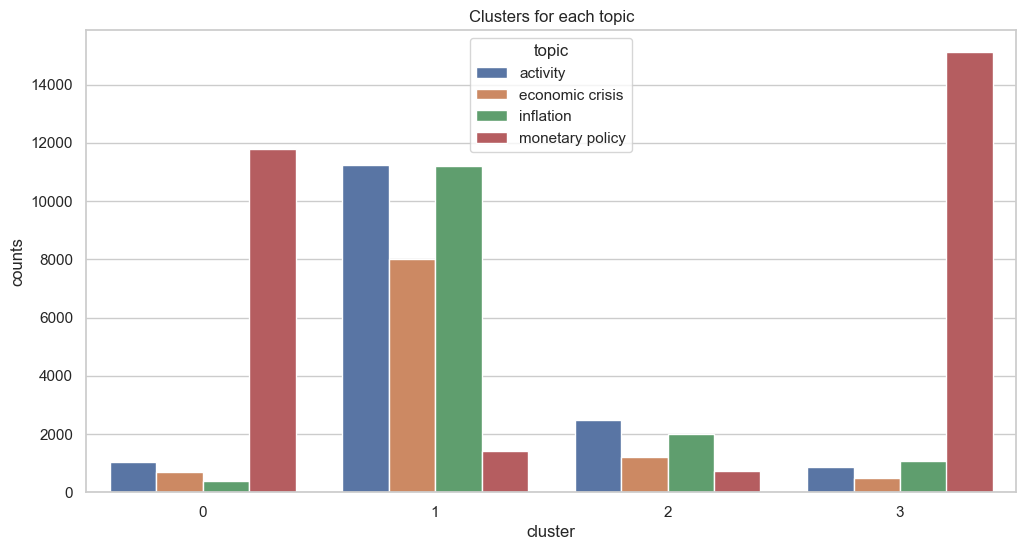

In [ ]:
# plot the clusters for each topic
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.barplot(x='cluster', y='counts', hue='topic', data=grouped)
plt.title('Clusters for each topic')
plt.show()


In [ ]:

def KMeans_clustering(X,num_clusters=4):
    new_df = data.copy()
# Determine the number of clusters
    # Execute K-means clustering
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(X)

    # Get cluster labels for each text
    cluster_labels = kmeans.labels_

    # Add cluster labels to the DataFrame
    new_df['cluster'] = cluster_labels

    return new_df

    


In [ ]:
data_kmeans_3 = KMeans_clustering(X,data,4)

c:\Users\Lavin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ValueError: Length of values (323796) does not match length of index (2524)

In [ ]:
data_kmeans_4 = KMeans_clustering(X,data,4)
# Save the data
data_kmeans_4.to_excel('data_kmeans_4.xlsx',index=False)


c:\Users\Lavin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
[('bank', 6797), ('payment', 5506), ('euro', 5472), ('financial', 4425), ('market', 4414), ('european', 4134), ('central', 4019), ('area', 3408), ('ecb', 3188), ('would', 3178), ('policy', 2985), ('risk', 2925), ('system', 2490), ('monetary', 2449), ('country', 2308), ('wa', 2216), ('economic', 2204), ('need', 2099), ('europe', 2063), ('new', 2004)] 

Cluster 1:
[('euro', 20255), ('area', 15551), ('policy', 12102), ('country', 9848), ('market', 9712), ('monetary', 9294), ('economic', 9224), ('growth', 8119), ('european', 7038), ('rate', 6892), ('financial', 6650), ('price', 6074), ('stability', 5473), ('economy', 5451), ('would', 4901), ('bank', 4732), ('fiscal', 4643), ('currency', 4580), ('state', 4471), ('ecb', 4471)] 

Cluster 2:
[('policy', 21070), ('monetary', 17199), ('inflation', 13797), ('rate', 11844), ('price', 11191), ('bank', 10465), ('euro', 9229), ('area', 8733), ('market', 7138), ('economic', 6978), ('central', 6789), ('financial', 6692), ('ecb', 6435), ('sta

In [ ]:
# Cluster 0 seems to be about activity
# Cluster 1 seems to be the about monetary policy
# Cluster 2 seems to be about inflation
# Cluster 3 seems to be about economic crisis
# Rename the clusters
data_kmeans_4['cluster'] = data_kmeans_4['cluster'].replace({0: 'activity', 1: 'monetary policy', 2: 'inflation', 3: 'economic crisis'})

In [ ]:
data_kmeans_5 = KMeans_clustering(X,data,5)
# Save the data
data_kmeans_5.to_excel('data_kmeans_5.xlsx',index=False)

c:\Users\Lavin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster 0:
[('bank', 4621), ('euro', 3833), ('financial', 3809), ('market', 3263), ('european', 3217), ('policy', 3084), ('central', 2876), ('area', 2792), ('ecb', 2710), ('risk', 2616), ('monetary', 2342), ('economic', 2237), ('would', 2180), ('country', 2123), ('wa', 1978), ('economy', 1795), ('see', 1724), ('year', 1699), ('europe', 1647), ('one', 1624)] 

Cluster 1:
[('policy', 19073), ('monetary', 15385), ('inflation', 13369), ('rate', 10992), ('price', 10089), ('bank', 9459), ('euro', 8211), ('area', 7974), ('market', 6423), ('economic', 6192), ('financial', 6152), ('central', 5999), ('ecb', 5675), ('stability', 5290), ('economy', 5160), ('interest', 4769), ('growth', 4694), ('risk', 4360), ('would', 4068), ('time', 3772)] 

Cluster 2:
[('financial', 20219), ('bank', 14958), ('market', 14899), ('risk', 8654), ('policy', 7254), ('euro', 6906), ('area', 6896), ('banking', 6213), ('system', 5456), ('crisis', 5106), ('stability', 5088), ('central', 4908), ('european', 4832), ('moneta

In [ ]:
# Cluster 0 seems to be about monetary policy
# Cluster 1 seems to be the about inflation
# Cluster 2 seems to be about digital euro
# Cluster 3 seems to be about economic activity
# Cluster 4 seems to be about economic instability


# Gráficos

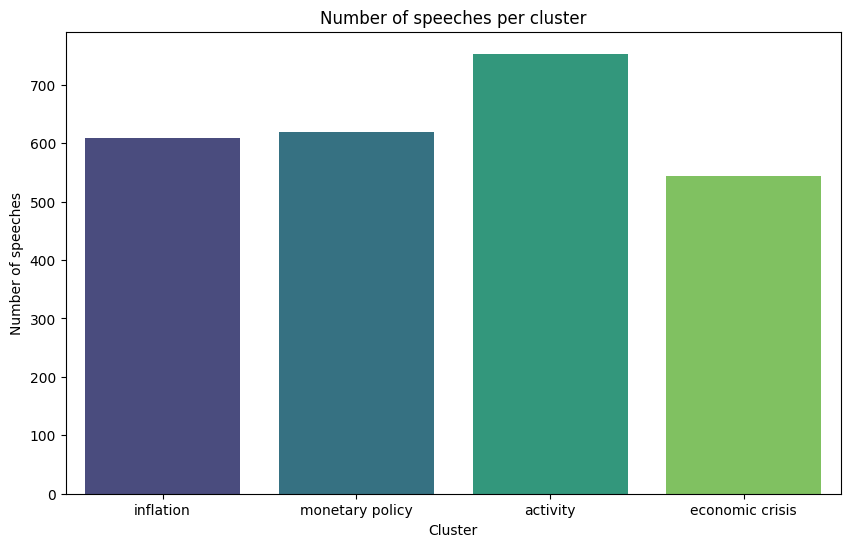

In [ ]:
# Histogram of the clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=data_kmeans_4, x='cluster', palette='viridis')
plt.title('Number of speeches per cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of speeches')
plt.show()


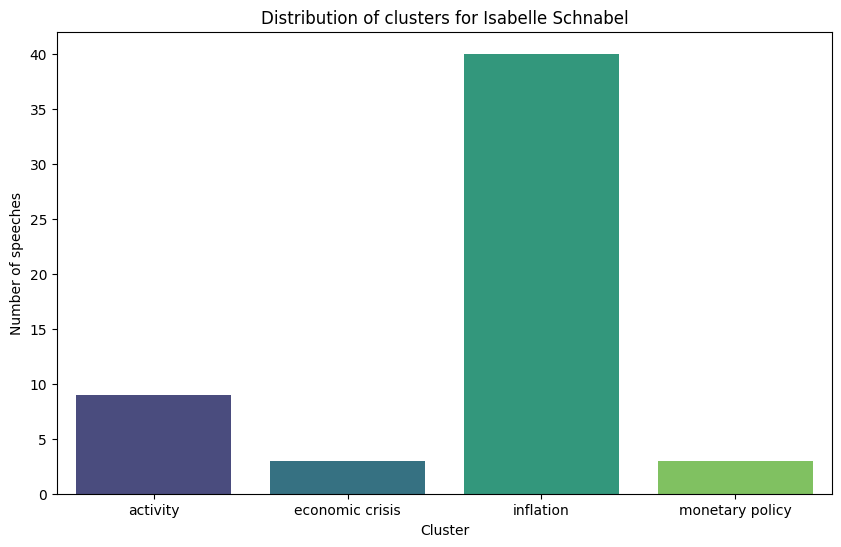

In [ ]:
# Plot the distribution of the clusters for speakers in a stacked bar plot

# Use Isabelle Schnabel as an example
example = data_kmeans_4[data_kmeans_4['speakers'] == 'Isabel Schnabel']
example = example.groupby(['speakers', 'cluster']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=example, x='cluster', y='count', palette='viridis')
plt.title('Distribution of clusters for Isabelle Schnabel')
plt.xlabel('Cluster')
plt.ylabel('Number of speeches')
plt.show()



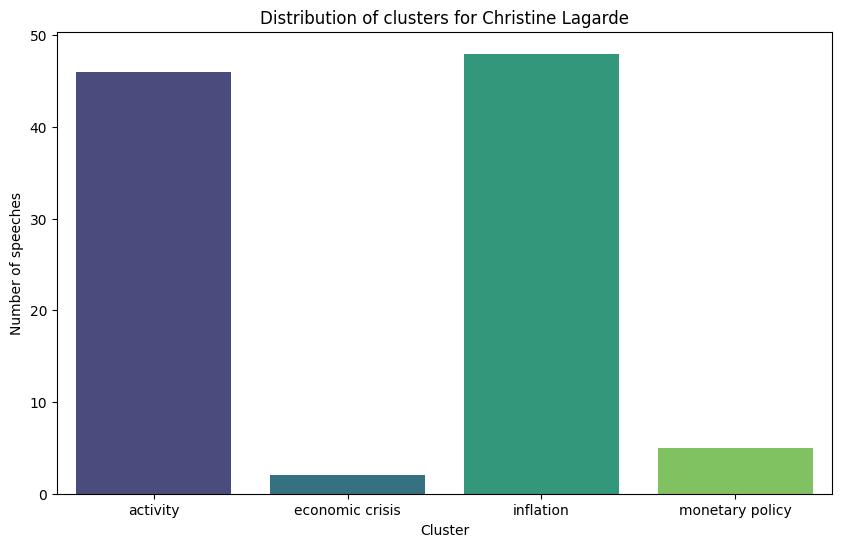

In [ ]:
# Plot the distribution of the clusters for speakers in a stacked bar plot

# Use Christine Lagarde as an example
example = data_kmeans_4[data_kmeans_4['speakers'] == 'Christine Lagarde']
example = example.groupby(['speakers', 'cluster']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=example, x='cluster', y='count', palette='viridis')
plt.title('Distribution of clusters for Christine Lagarde')
plt.xlabel('Cluster')
plt.ylabel('Number of speeches')
plt.show()



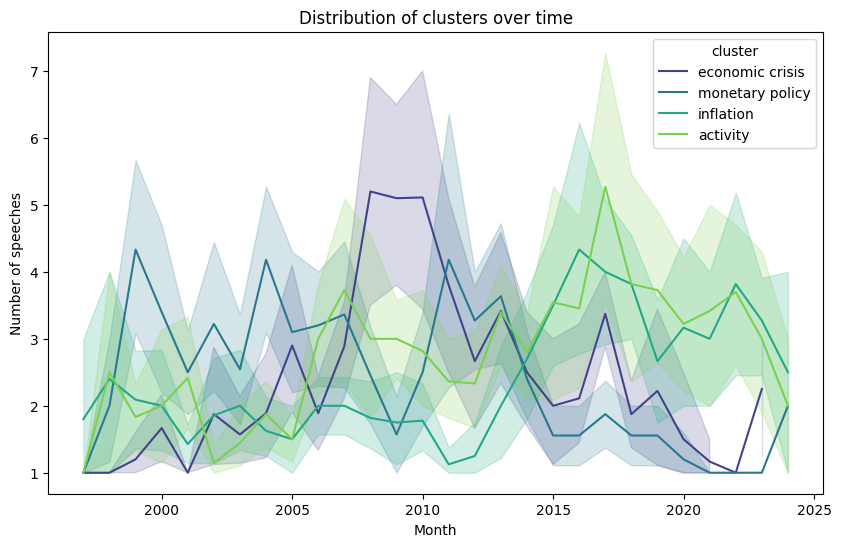

In [ ]:
# Line plot of clusters over time per month and year
data_kmeans_4['year'] = pd.to_datetime(data_kmeans_4['date']).dt.year
example = data_kmeans_4.groupby(['year', 'cluster']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.lineplot(data=example, x='year', y='count', hue='cluster', palette='viridis')
plt.title('Distribution of clusters over time')
plt.xlabel('year')
plt.ylabel('Number of speeches')
plt.show()



C:\Users\Lavin\AppData\Local\Temp\ipykernel_10956\1565357728.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example['year'] = example['date'].dt.year
C:\Users\Lavin\AppData\Local\Temp\ipykernel_10956\1565357728.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  example['month'] = example['date'].dt.month
C:\Users\Lavin\AppData\Local\Temp\ipykernel_10956\1565357728.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

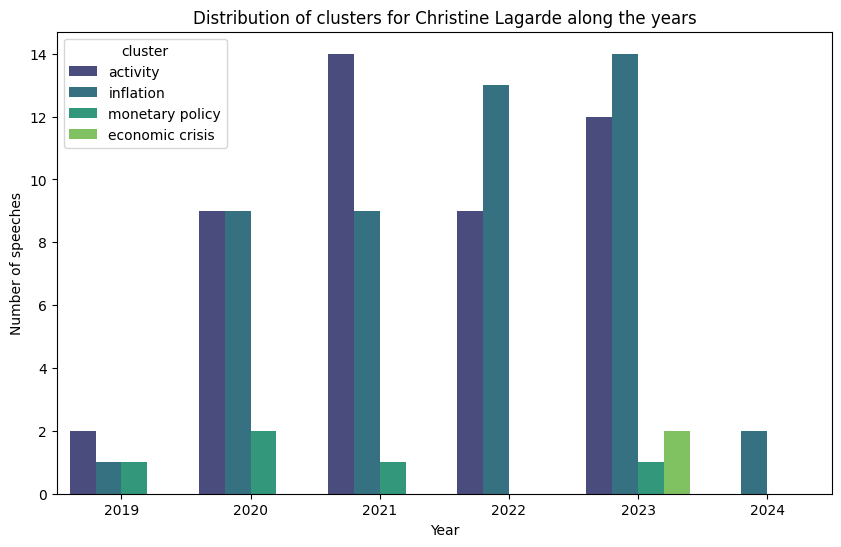

In [ ]:
# topics along the years for a specific speaker
# Use Christine Lagarde as an example
data_kmeans_4['date'] = pd.to_datetime(data_kmeans_4['date'])
example = data_kmeans_4[data_kmeans_4['speakers'] == 'Christine Lagarde']
# plot the distribution of the clusters for Christine Lagarde along the trimesters
example['year'] = example['date'].dt.year
example['month'] = example['date'].dt.month
example['trimester'] = example['month'].apply(lambda x: (x-1)//3+1) 
example = example.groupby(['year', 'cluster']).size().reset_index(name='count')
plt.figure(figsize=(10, 6))
sns.barplot(data=example, x='year', y='count', hue='cluster', palette='viridis')
plt.title('Distribution of clusters for Christine Lagarde along the years')
plt.xlabel('Year')
plt.ylabel('Number of speeches')
plt.show()



In [ ]:
example

,year,cluster,count
0,2019,activity,2
1,2019,inflation,1
2,2019,monetary policy,1
3,2020,activity,9
4,2020,inflation,9
5,2020,monetary policy,2
6,2021,activity,14
7,2021,inflation,9
8,2021,monetary policy,1
9,2022,activity,9
